#### Importing the necessary libraries

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import nltk
import re
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import models
from keras import layers,regularizers,optimizers
from keras.models import Sequential
from keras.layers import Dropout,Activation,LSTM,Dense,Embedding,Input

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Reading the data

In [3]:
data = pd.read_csv('tweet_product_company.csv',encoding='latin-1')
data.head(15)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


This is the data we have let us check the overall information of the dataset.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


So as we can see the dataset has different count of values in the rows.
For the purpose of the project is sentiment analysis, I chose the columns the necessary columns from the dataset.

In [5]:
# Keeping the necessary columns
data = data[['tweet_text','is_there_an_emotion_directed_at_a_brand_or_product']]
data

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion
...,...,...
9088,Ipad everywhere. #SXSW {link},Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,No emotion toward brand or product


#### Data Preprocessing

These columns have really long names so I renamed the column names to simplify the column names.

In [6]:
data.rename(columns = {'tweet_text' : 'text'},inplace=True)
data.rename(columns = {'is_there_an_emotion_directed_at_a_brand_or_product' : 'sentiment'},inplace=True)

There we have it the column names are better than before so let us process this dataset for sentiment analysis.

So now that we have the columns necessary in the dataset we can check the overall information of the dataset again.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       9092 non-null   object
 1   sentiment  9093 non-null   object
dtypes: object(2)
memory usage: 142.2+ KB


The dataset has columns with different range of row values but since the missing values are equal to 1. I chose to impute the missing value using a constant value.

In [8]:
data['text'] = data['text'].fillna(value='Unknown')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       9093 non-null   object
 1   sentiment  9093 non-null   object
dtypes: object(2)
memory usage: 142.2+ KB


Perfect! Now our columns have the same number of rows in data.

Let us continue exploring this dataset specifically the types of emotions in the 'sentiment' column as to identify what we are really dealing with.

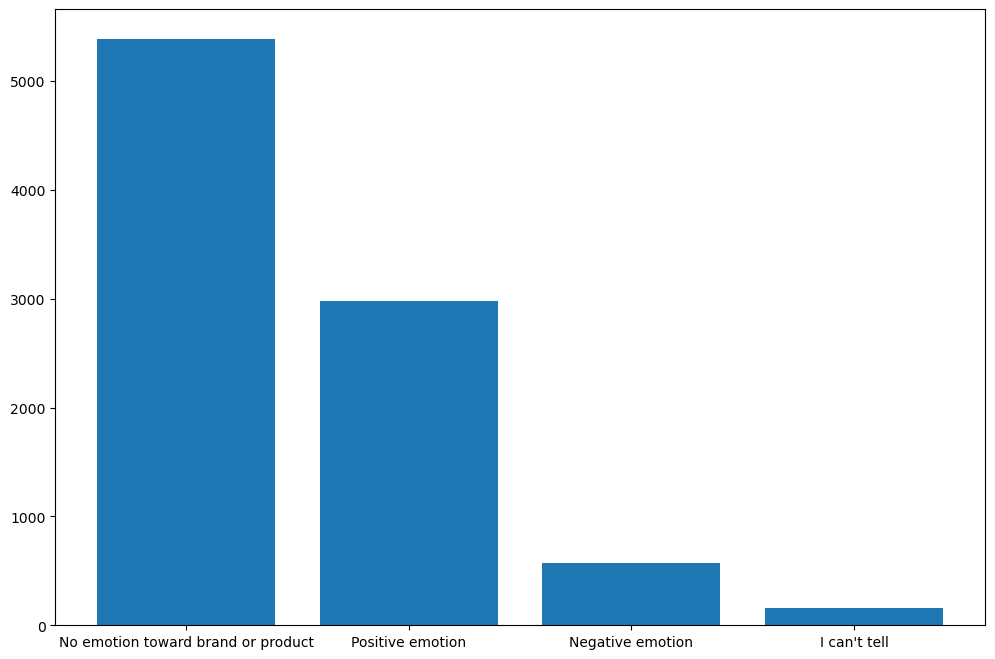

In [14]:
# Identifys the distribution between labels in the target variable 'sentiment'
sentiment_counts = data['sentiment'].value_counts()
labels = sentiment_counts.index
frequencies = sentiment_counts.values
plt.figure(figsize=(12,8))
plt.bar(labels,frequencies)
plt.show()

In [11]:
data['sentiment'].value_counts()

sentiment
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

As we can see the dataset we have has four different types of emotions which are all valid. Let us start by building a binary classifier; this mean limiting the sentiment analysis to tweets that were identified as potraying negative or positive emotion.

(A multi-classifier will be built later)

In [23]:
data = data.copy()
data = data[data.sentiment != 'No emotion toward brand or product']
data = data[data.sentiment != "I can't tell"]
print(data[data['sentiment'] == 'Positive emotion'].size)
print(data[data['sentiment'] == 'Negative emotion'].size)
data['sentiment'].value_counts()

5956
1140


sentiment
Positive emotion    2978
Negative emotion     570
Name: count, dtype: int64

So what I have done in the cell above is made a copy of the dataset. The next step was to filter out the tweets that did not have positive or negative emotion as for a binary classifier I was only interested with positive and negative tweets.

There are many different approaches that are viable options for sentiment analysis and with experimentation of the options, the aim is to obtain the best possible solution. Let us begin with the automatic approaches that is machine learning models.

#### Getting ready for Deep NLP

Deep NLP involves the application the Recurrent Neural Network model which is a sequence model that is able to focus on order of words hence capturing information quite effectively.

First I split the dataset into X and Y .

In [31]:
X = data['text']
y = data['sentiment']

Train-Test split

The data is split into training and test sets and in this case I assigned 1500 observations to the test and seed to 42.

In [32]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1500,random_state=42)

I created a Validation set as well as the model created is highly likely to be subject to hyperparameter tuning, and so the validation set will be used until a final model is decided upon. The final model will then be tested on the unseen test data that will provide an unbiased performance of the final model.

In [35]:
# Splits data into training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(X,y,test_size=1000,random_state=42)


I used Tokenizer from keras preprocessing:  

Tokenizer is a class provided by Keras, specifically designed 
for text tokenization and preprocessing in deep learning models.

This tokenizer also converts tokens to sequences.

In [51]:
tokenizer = Tokenizer()
# Fit the tokenizer to training data
tokenizer.fit_on_texts(X_train_final)

# Converting the text sequences to token sequences
X_train_tokens = tokenizer.texts_to_sequences(X_train_final)
X_test_tokens = tokenizer.texts_to_sequences(X_test)
X_val_tokens = tokenizer.texts_to_sequences(X_val)

# Find the maximum sequence length
max_sequence_length = max(len(seq) for seq in X_train_tokens + X_val_tokens + X_test_tokens)

# Pad sequences separately to ensure all inputs have the same shape
train_padded_sequences = pad_sequences(X_train_tokens, maxlen=max_sequence_length)
test_padded_sequences = pad_sequences(X_test_tokens, maxlen=max_sequence_length)
val_padded_sequences = pad_sequences(X_val_tokens, maxlen=max_sequence_length)
# Print the padded sequences
print("Train Padded Sequences:")
print(train_padded_sequences)
print("\nTest Padded Sequences:")
print(test_padded_sequences)
print("\nValidation Padded Sequences:")
print(val_padded_sequences)

Train Padded Sequences:
[[   0    0    0 ...  247  182 2544]
 [   0    0    0 ...  554    1    5]
 [   0    0    0 ...  211    2    1]
 ...
 [   0    0    0 ...   34  901    5]
 [   0    0    0 ...   13  571    1]
 [   0    0    0 ...    1 1039 2491]]

Test Padded Sequences:
[[   0    0    0 ...    5    1   80]
 [   0    0    0 ...   18    1  606]
 [   0    0    0 ... 2779 2442    1]
 ...
 [   0    0    0 ...    7    1    5]
 [   0    0    0 ...  235  211    1]
 [   0    0    0 ...   13  726    1]]

Validation Padded Sequences:
[[   0    0    0 ...    5    1   80]
 [   0    0    0 ...   18    1  606]
 [   0    0    0 ... 2779 2442    1]
 ...
 [   0    0    0 ...   91   11  297]
 [   0    0    0 ...   44   16 1249]
 [   0    0    0 ...  173   12   45]]


The sequences above are now fully converted into integers bt to be able to fit an RNN model, I needed to convert these sequence of integers to vector repesentations.

The next step is to transform the labels of the product to integer labels which is similar to one-hot encoding.

In [52]:
labels = LabelBinarizer()

labels.fit(y_train_final)
classes = 2
y_train_lb = to_categorical(labels.transform(y_train_final),classes)
y_val_lb = to_categorical(labels.transform(y_val),classes)
y_test_lb = to_categorical(labels.transform(y_test),classes)

The next step is to compose a LSTM network which is part of RNN architecure. 

But first let us use the technique that is word embeddings to convert these sequences of integers into vector representations.

Word Embeddings are dense vector representations of words in a high-dimensional space. The purpose of word embeddings is to capture the meaning and interpretation of words; semantic relationships that is.

Word embeddings have benefits such as representing text/words as dense vectors of fixed dimensions allowing for much more efficient storage and computation, among other things such as capturing semantic relationships.

Word embeddings prove to be very useful to an LSTM network as the model is able to effectively process sequential data,generaliz well and leverage pre-trained linguistic knowledge.

In [54]:
# In this case I used an embedding layer that is a layer that
# learns word embeddings for our dataset right inside a neural
# network


#### Baseline Model

I defined the network architecture and added number of layers as well as activation functions.

I also added regularization layers (Dropout) to the network to prevent overfitting the model.

In [79]:
#Input shape is the vocabulary size
vocab_size = len(tokenizer.word_index) + 1
model = Sequential()
embedding_size = 128
model.add(Embedding(vocab_size,embedding_size))
model.add(LSTM(25, return_sequences=True))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))# Use 2 units in output layer for binary classification. 


Once you have designed the model, you still have to compile it, and provide important parameters such as the loss function.

Since I started with binary classification I used 'adam' as the optimizer. 

Adam is used for its robust performance on a wide range of tasks and is often a good choice for binary classification. 

In [80]:
model.compile(loss='categorical_crossentropy',optimizer='adam',
              metrics=['accuracy'])

I used the metric accuracy as according to our business 
understanding I needed to build a model that will accurately rate the sentiment from a tweet based on its content.

In [81]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         676992    
                                                                 
 lstm_2 (LSTM)               (None, None, 25)          15400     
                                                                 
 dropout_4 (Dropout)         (None, None, 25)          0         
                                                                 
 dense_4 (Dense)             (None, None, 50)          1300      
                                                                 
 dropout_5 (Dropout)         (None, None, 50)          0         
                                                                 
 dense_5 (Dense)             (None, None, 2)           102       
                                                                 
Total params: 693794 (2.65 MB)
Trainable params: 69379

Finally, I fit the model by passing in data, the labels and setting hyperparameters such as the batch size, number of epochs to train for and training and validation data.

In [82]:
baseline_model_val = model.fit(train_padded_sequences,y_train_lb,epochs=3,
          batch_size=32,validation_data=
          (val_padded_sequences,y_val_lb))

Epoch 1/3


ValueError: in user code:

    File "c:\Users\HP\anaconda3_2.0\envs\learn-env\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\HP\anaconda3_2.0\envs\learn-env\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\HP\anaconda3_2.0\envs\learn-env\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\HP\anaconda3_2.0\envs\learn-env\lib\site-packages\keras\src\engine\training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\HP\anaconda3_2.0\envs\learn-env\lib\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "c:\Users\HP\anaconda3_2.0\envs\learn-env\lib\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\HP\anaconda3_2.0\envs\learn-env\lib\site-packages\keras\src\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\HP\anaconda3_2.0\envs\learn-env\lib\site-packages\keras\src\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\HP\anaconda3_2.0\envs\learn-env\lib\site-packages\keras\src\losses.py", line 2122, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\HP\anaconda3_2.0\envs\learn-env\lib\site-packages\keras\src\backend.py", line 5560, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 2) and (None, 33, 2) are incompatible


In [74]:
print(val_padded_sequences.shape)
print(train_padded_sequences.shape)
print(y_train_lb)
print(y_test_lb)

(1000, 33)
(2548, 33)
[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]
